In [0]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import numpy as np
import re
import gensim
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [0]:
nltk.download('stopwords')

In [0]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z!]+"
DATASET_ENCODING = "ISO-8859-1"

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
df = pd.read_csv('/content/drive/My Drive/essays_augmented.csv')

In [0]:
abbr={"ain't": "is not", "isn't": 'is not',"cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', '2F4U':	'Too Fast For You',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'AKA':	'also known as', 'ACK':	'Acknowledgment', 'AFAIK':	'As far as I know', 'AFAIR':	'As far as I remember'}

abbr = {k.lower(): v.lower() for k, v in abbr.items()}

In [0]:
def normalize_word(word):
    temp = word
    while True:
        w = re.sub(r"([a-zA-Z])\1\1", r"\1\1", temp)
        if (w == temp):
            break
        else:
            temp = w
    return w

In [0]:
def preprocess(text,abbreviation_dict=abbr, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()

    filtered_text=[]
    for t in text.split(' '):
        if (t in abbreviation_dict):
            tok = abbreviation_dict.get(t).split(' ')
            filtered_text.extend(tok)
        else:
            filtered_text.append(t)

    tokee=[normalize_word(word) for word in filtered_text]
    tokee=[t for t in tokee if t not in stop_words]

    tokens = []
    for token in tokee:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    ll=['b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    tokens=[g for g in tokens if g not in ll]
    if len(tokens)>=1:
        return " ".join(tokens)
    else:
        return float('NaN')
df.TEXT = df.TEXT.apply(lambda x: preprocess(x))

In [0]:
df=df.dropna(axis=0,how='any')

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.TEXT)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 34649


In [12]:
max([len(s.split(' ')) for s in list(df['TEXT']) ])

1000

In [0]:
X = pad_sequences(tokenizer.texts_to_sequences(df.TEXT), maxlen=1000)

In [0]:
encoder = LabelEncoder()
encoder.fit(df['cEXT'].tolist())
y = encoder.transform(df['cEXT'].tolist())
y = y.reshape(-1,1)

In [15]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

In [0]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=1000, trainable=False)

In [19]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         10394700  
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 128)          115328    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 256)          0         
_________________________________________________________________
flatten (Flatten)            (None, 63488)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

In [22]:
history = model.fit(X,y,
                    batch_size=256,
                    epochs=15,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/15
84/84 [==============================] - 25s 302ms/step - loss: 0.7224 - accuracy: 0.5161 - val_loss: 0.6916 - val_accuracy: 0.5212
Epoch 2/15
84/84 [==============================] - 25s 294ms/step - loss: 0.6645 - accuracy: 0.5920 - val_loss: 0.6834 - val_accuracy: 0.5807
Epoch 3/15
84/84 [==============================] - 25s 293ms/step - loss: 0.4130 - accuracy: 0.8204 - val_loss: 0.7625 - val_accuracy: 0.6082
Epoch 4/15
84/84 [==============================] - 25s 292ms/step - loss: 0.1073 - accuracy: 0.9719 - val_loss: 0.7949 - val_accuracy: 0.6837
Epoch 5/15
84/84 [==============================] - 25s 292ms/step - loss: 0.0218 - accuracy: 0.9974 - val_loss: 0.7855 - val_accuracy: 0.7257
Epoch 6/15
84/84 [==============================] - 25s 292ms/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 0.7568 - val_accuracy: 0.7472
Epoch 7/15
84/84 [==============================] - 25s 293ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7712 - val_accuracy: 0.7583

In [0]:
# PLOT MODEL
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [0]:
model.save('/content/drive/My Drive/CNNext.h5') 

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/CNNext.h5')

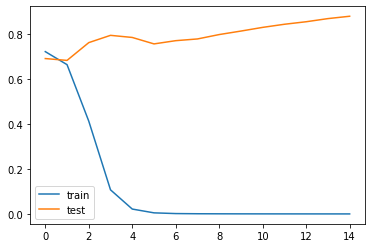

In [23]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
df1 = pd.read_csv('/content/drive/My Drive/sarcastic_comments.csv',low_memory=False)

In [0]:
Z=pd.to_numeric(df1.label,downcast='integer',errors='coerce')
df1['z']=Z

In [0]:
def preprocess(text,abbreviation_dict=abbr, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()

    filtered_text=[]
    for t in text.split(' '):
        if (t in abbreviation_dict):
            tok = abbreviation_dict.get(t).split(' ')
            filtered_text.extend(tok)
        else:
            filtered_text.append(t)

    tokee=[normalize_word(word) for word in filtered_text]
    tokee=[t for t in tokee if t not in stop_words]

    tokens = []
    for token in tokee:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    ll=['b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    tokens=[g for g in tokens if g not in ll]
    if len(tokens)>=8:
        return " ".join(tokens)
    else:
        return float('NaN')
df1.comment = df1.comment.apply(lambda x: preprocess(x))

In [0]:
df1=df1.dropna(axis=0,how='any')

In [0]:
X1 = pad_sequences(tokenizer.texts_to_sequences(df1.comment), maxlen=1000)

In [0]:
X1.shape

(225268, 1000)

In [0]:
import tensorflow
new_input = model.input
hidden_layer = model.layers[-2].output

features_extract_model = tensorflow.keras.Model(new_input, hidden_layer)
features_extract_model.trainable=False

In [0]:
tf.executing_eagerly()

True

In [0]:
I=[i for i in range(0,X1.shape[0],1000)]
I.append(X1.shape[0])

In [0]:
NDF=pd.DataFrame(columns=[str(t) for t in range(128)])
for i in range(len(I[0:-1])):
    x=tf.convert_to_tensor(X1[I[i]:I[i+1]])
    z=features_extract_model(x)
    ndf=pd.DataFrame(z.numpy(),columns=[str(t) for t in range(128)])
#    NDF.append(ndf,ignore_index = True)
    lst = [NDF, ndf]
    NDF = pd.concat(lst)

In [0]:
NDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000000,1.083195,0.0,0.0,0.0,0.0,1.108587,1.098307,0.000000,0.000000,0.0,1.125321,0.0,0.0,0.000000,1.042915,1.156994,1.018677,0.000000,0.000000,0.0,0.0,0.000000,1.056336,0.000000,0.0,0.938388,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.209896,0.000000,0.0,...,1.045751,0.000000,0.982115,0.000000,1.003293,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.906293,0.0,1.139387,0.0,0.000000,0.000000,0.000000,1.027214,0.0,0.0,1.151642,0.0,0.000000,0.0,0.0,0.0,0.0,1.177093,0.000000,0.0,0.971527,1.025842,0.0,0.0,0.000000,0.000000,0.0,1.078398,0.0
1,0.000000,1.012239,0.0,0.0,0.0,0.0,1.045326,1.004387,0.000000,0.000000,0.0,1.050331,0.0,0.0,0.000000,0.957503,1.052984,0.972564,0.000000,0.000000,0.0,0.0,0.000000,0.955026,0.000000,0.0,0.846808,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.194871,0.000000,0.0,...,0.954671,0.000000,0.924025,0.000000,0.926523,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.818921,0.0,1.096501,0.0,0.000000,0.000000,0.000000,0.937611,0.0,0.0,1.102049,0.0,0.000000,0.0,0.0,0.0,0.0,1.101167,0.000000,0.0,0.906486,0.955095,0.0,0.0,0.000000,0.000000,0.0,1.004038,0.0
2,0.000000,1.022136,0.0,0.0,0.0,0.0,1.009140,0.986705,0.000000,0.000000,0.0,1.034304,0.0,0.0,0.000000,0.912504,1.090400,0.936295,0.000000,0.000000,0.0,0.0,0.000000,0.938967,0.000000,0.0,0.776047,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.225287,0.000000,0.0,...,0.909281,0.000000,0.907130,0.000000,0.910282,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.800676,0.0,1.078972,0.0,0.000000,0.000000,0.000000,0.912328,0.0,0.0,1.117501,0.0,0.000000,0.0,0.0,0.0,0.0,1.088598,0.000000,0.0,0.849576,0.915839,0.0,0.0,0.000000,0.000000,0.0,0.975424,0.0
3,0.000000,0.768675,0.0,0.0,0.0,0.0,0.734603,0.726776,0.000000,0.000000,0.0,0.796847,0.0,0.0,0.000000,0.672282,0.817121,0.735735,0.000000,0.000000,0.0,0.0,0.000000,0.739380,0.000000,0.0,0.647685,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.905246,0.000000,0.0,...,0.703733,0.000000,0.697051,0.000000,0.715547,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.631993,0.0,0.835834,0.0,0.000000,0.000000,0.000000,0.723471,0.0,0.0,0.897355,0.0,0.000000,0.0,0.0,0.0,0.0,0.827506,0.000000,0.0,0.667232,0.698266,0.0,0.0,0.000000,0.000000,0.0,0.734252,0.0
4,0.118118,0.486146,0.0,0.0,0.0,0.0,0.528444,0.505420,0.183568,0.266973,0.0,0.575548,0.0,0.0,0.171294,0.495807,0.570832,0.546959,0.096052,0.201940,0.0,0.0,0.262269,0.524895,0.166989,0.0,0.352291,0.229984,0.0,0.0,0.186501,0.0,0.0,0.0,0.0,0.149656,0.186983,0.817922,0.185722,0.0,...,0.390696,0.139455,0.519607,0.078403,0.526356,0.326965,0.094922,0.241473,0.0,0.0,0.0,0.335384,0.0,0.566246,0.0,0.135860,0.188990,0.274411,0.525024,0.0,0.0,0.713664,0.0,0.093469,0.0,0.0,0.0,0.0,0.667091,0.032907,0.0,0.499416,0.505934,0.0,0.0,0.139253,0.177208,0.0,0.457358,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.288646,0.699073,0.0,0.0,0.0,0.0,0.700198,0.641229,0.321747,0.410175,0.0,0.736177,0.0,0.0,0.251250,0.708764,0.603609,0.686361,0.239135,0.421674,0.0,0.0,0.360229,0.640498,0.335657,0.0,0.451157,0.395114,0.0,0.0,0.364953,0.0,0.0,0.0,0.0,0.289374,0.240890,1.032847,0.341202,0.0,...,0.586108,0.244802,0.653801,0.109990,0.589449,0.440971,0.274187,0.391266,0.0,0.0,0.0,0.398977,0.0,0.682734,0.0,0.293134,0.334416,0.338628,0.673937,0.0,0.0,0.811600,0.0,0.248366,0.0,0.0,0.0,0.0,0.917394,0.223944,0.0,0.562847,0.624065,0.0,0.0,0.243191,0.325312,0.0,0.582295,0.0
264,0.000000,0.904176,0.0,0.0,0.0,0.0,0.907066,0.787763,0.000000,0.0000

In [0]:
NDF.to_csv('/content/drive/My Drive/personality_opn.csv')